In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sn

import whois

### Reading Data

In [5]:
# Reading data from csv file
data = pd.read_csv("data.csv")
data.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [3]:
data.shape

(420464, 2)

In [4]:
data['label'].unique()

array(['bad', 'good'], dtype=object)

### Data Preprocessing

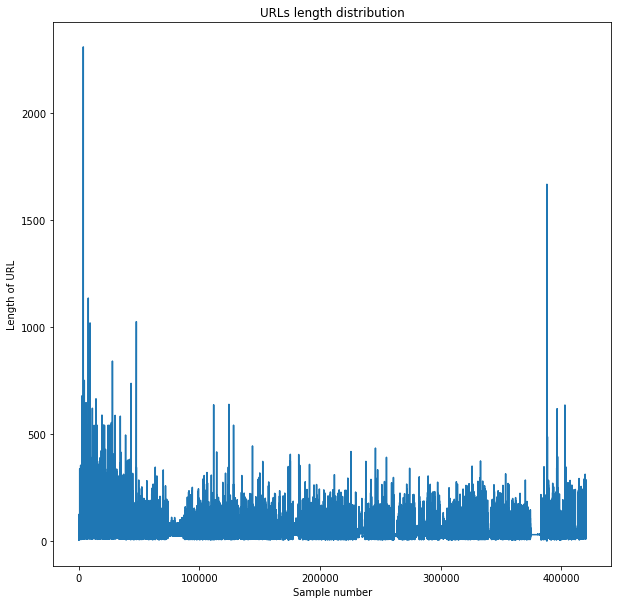

In [4]:
def plot_sample_length_distribution(urls):
    plt.figure(figsize=(10,10))
    plt.plot([x for x in range(len(urls))], [len(s) for s in urls])
#     plt.hist([len(s) for s in urls], 50)
    plt.xlabel('Sample number')
    plt.ylabel('Length of URL')
    plt.title('URLs length distribution')
    plt.show()

plot_sample_length_distribution(data['url'])

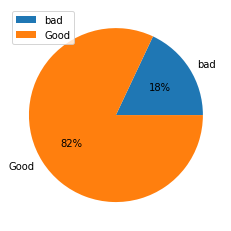

In [18]:
counts = data.groupby(['label']).size()

plt.pie(counts, labels = ['bad', 'Good'], autopct='%.0f%%')
plt.legend()


#### malicious = 1 <br> Normal = 0

In [7]:
data['label'] = np.where(data['label']=='bad',1,0)

In [8]:
# get target feature
y = data["label"]

# get dependent features
urls = data["url"]

In [9]:
# Split into training and testing dataset 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(urls, y, test_size=0.2, random_state=42)

### Creating TF-IDF Vectors 

In [10]:
# Using Tokenizer
vectorizer = TfidfVectorizer(max_features=10000)

# creating tf-idf vectors for traning data
X_train_tf_idf = vectorizer.fit_transform(X_train)
# creating tf-idf vectors for testing data
X_test_tf_idf = vectorizer.transform(X_test)

### Applying Logistic Regression

In [72]:
# Model Building using logistic regression
logit = LogisticRegression()
logit.fit(X_train_tf_idf, y_train)

c:\Users\ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
y_pred = logit.predict(X_test_tf_idf)

In [74]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
# Accuracy of Our Model
print("Accuracy of Logistic Regression model is: ",ac)

Accuracy of Logistic Regression model is:  0.960448551009002


<AxesSubplot:>

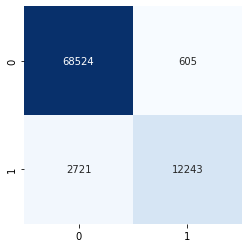

In [75]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     69129
           1       0.95      0.82      0.88     14964

    accuracy                           0.96     84093
   macro avg       0.96      0.90      0.93     84093
weighted avg       0.96      0.96      0.96     84093



### Applying Naive Bayes

In [77]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tf_idf, y_train)

MultinomialNB()

In [78]:
y_pred = mnb.predict(X_test_tf_idf)

In [79]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
# Accuracy of Our Model
print("Accuracy of SVM model is: ",ac)

Accuracy of SVM model is:  0.9574637603605533


<AxesSubplot:>

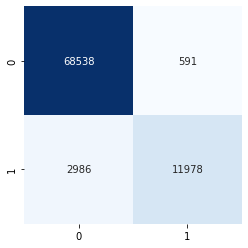

In [80]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     69129
           1       0.95      0.80      0.87     14964

    accuracy                           0.96     84093
   macro avg       0.96      0.90      0.92     84093
weighted avg       0.96      0.96      0.96     84093



### Applying Decision Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train_tf_idf, y_train)

DecisionTreeClassifier(criterion='entropy')

In [83]:
y_pred = dtc.predict(X_test_tf_idf)

In [84]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
# Accuracy of Our Model
print("Accuracy of SVM model is: ",ac)

Accuracy of SVM model is:  0.957237820032583


<AxesSubplot:>

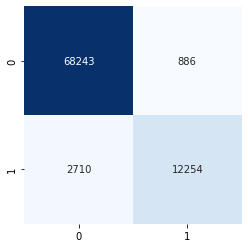

In [85]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     69129
           1       0.93      0.82      0.87     14964

    accuracy                           0.96     84093
   macro avg       0.95      0.90      0.92     84093
weighted avg       0.96      0.96      0.96     84093



### Extacting Domain level features

In [59]:
from tqdm import tqdm
import datetime
from tld import get_tld

In [60]:
w = whois.whois('tryjaar.com')

In [61]:
def extract_domain_features(data):
    today = datetime.datetime.now()
    domain_features = {"website_age" : [],
                    "website_last_updated_dur" : [],
                    "expiry_date" : [],
                    "country" :[],
                    "state" : [],
                    "tld":[ ]}  
    
    for url in tqdm(data):
        # get whois info
        try:
            whois_info = whois.whois(url)
            domain_features["website_age"].append((today - min(whois_info["creation_date"])).days) 
            domain_features["website_last_updated_dur"].append((today - max(whois_info["updated_date"])).days)
            domain_features["expiry_date"].append((min(whois_info["expiration_date"])-today).days)
            domain_features["country"].append(whois_info["country"])
            domain_features["state"].append(whois_info["state"])
            # get top level domain
            try:
                domain_tld = get_tld(url, fix_protocol=True)
            except:
                domain_tld = None
            print(domain_tld)
            domain_features["tld"].append(domain_tld)
            
        except:
            domain_features["website_age"].append(None) 
            domain_features["website_last_updated_dur"].append(None)
            domain_features["expiry_date"].append(None)
            domain_features["country"].append(None)
            domain_features["state"].append(None)
            domain_features["tld"].append(None)
            
    return domain_features

In [62]:
s = extract_domain_features(list(data["url"])[:10])

 10%|████████▎                                                                          | 1/10 [00:01<00:09,  1.08s/it]

com


 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.22it/s]

com


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:06,  1.36s/it]

net


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


In [102]:
s

{'website_age': [5718,
  None,
  5718,
  6163,
  None,
  6787,
  None,
  None,
  None,
  None,
  None],
 'website_last_updated_dur': [14,
  None,
  14,
  None,
  16,
  None,
  None,
  None,
  None,
  None],
 'expiry_date': [125, None, 125, None, 152, None, None, None, None, None],
 'country': ['US', None, 'US', None, 'US', None, None, None, None, None],
 'state': ['Arizona',
  None,
  'Arizona',
  None,
  'Arizona',
  None,
  None,
  None,
  None,
  None],
 'tld': ['com', None, 'com', None, 'net', None, None, None, None, None]}

In [84]:
get_tld("http://google.co.uk")

'co.uk'

In [51]:
w

{'domain_name': ['TRYJAAR.COM', 'tryjaar.com'],
 'registrar': 'REALTIME REGISTER B.V.',
 'whois_server': 'whois.yoursrs.com',
 'referral_url': None,
 'updated_date': [datetime.datetime(2022, 8, 9, 19, 55, 40),
  datetime.datetime(2022, 8, 29, 8, 41, 35)],
 'creation_date': datetime.datetime(2022, 8, 9, 19, 54, 22),
 'expiration_date': datetime.datetime(2023, 8, 9, 19, 54, 22),
 'name_servers': ['NS1.DNS-PARKING.COM',
  'NS2.DNS-PARKING.COM',
  'ns1.dns-parking.com',
  'ns2.dns-parking.com'],
 'status': ['clientTransferProhibited https://icann.org/epp#clientTransferProhibited',
  'ok http://www.icann.org/epp#ok',
  'clientTransferProhibited http://www.icann.org/epp#clientTransferProhibited'],
 'emails': ['rtr-security-threats@realtimeregister.com',
  'abuse@hostinger.com'],
 'dnssec': ['unsigned', 'not'],
 'name': 'REDACTED FOR PRIVACY',
 'org': 'REDACTED FOR PRIVACY',
 'address': 'REDACTED FOR PRIVACY',
 'city': 'REDACTED FOR PRIVACY',
 'state': 'Rajasthan',
 'registrant_postal_code': 

In [69]:
max(w["updated_date"])

datetime.datetime(2022, 8, 29, 8, 41, 35)

In [65]:
(today - w["creation_date"]).days

39

In [43]:
list(data['url'])[:10]

['diaryofagameaddict.com',
 'espdesign.com.au',
 'iamagameaddict.com',
 'kalantzis.net',
 'slightlyoffcenter.net',
 'toddscarwash.com',
 'tubemoviez.com',
 'ipl.hk',
 'crackspider.us/toolbar/install.php?pack=exe',
 'pos-kupang.com/']

In [99]:
  get_tld('espdesign.com.au', fix_protocol=True)

'com.au'